Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from scipy.fftpack import fft
%matplotlib inline

Read training data and manage NaN values by filling them with 0, then show the head

In [ ]:
train = pd.read_csv("data/train_1.csv").fillna(0)
train.head()

Cast every value to an integer number to save memory, floats take up more space

In [ ]:
for col in train.columns[1:]:
    train[col] = pd.to_numeric(train[col], downcast="integer")
train.head()

In [ ]:
train.info()

Is traffic influenced by page language?
Web traffic could be influenced by the language of the page, we can check this by using regular expressions

In [ ]:
def get_language(page):
    res = re.search("[a-z][a-z].wikipedia.org", page)
    if res:
        return res[0][0:2]
    # return 'na' in the case of a wikimedia pages
    return "na"
train["lang"] = train.Page.map(get_language)
print(Counter(train.lang))

The problematic part of this dataset is that since we have different languages we also have different writing systems to deal with (Latin, Cyrillic, Chinese and Japanese)
Let's create a different dataset for each language

In [9]:
lang_sets = {}
for lang in pd.unique(train["lang"]):
    # iloc to -1 means "to the last" (excluded). The last columns is "lang"
    lang_sets[lang] = train[train.lang==lang].iloc[:, 0:-1]
sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

Let's plot how the total number of views change over time

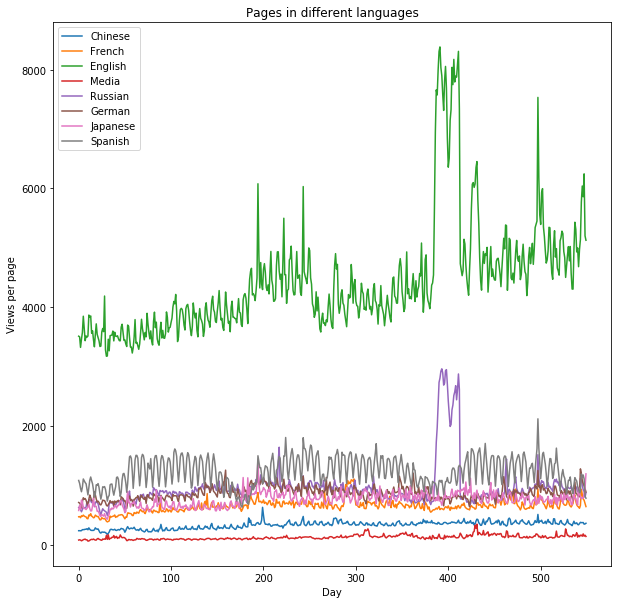

In [10]:
days = [r for r in range(sums["en"].shape[0])]

fig = plt.figure(1, figsize=[10, 10])
plt.ylabel("Views per page")
plt.xlabel("Day")
plt.title("Pages in different languages")
labels={"en": "English", "ja": "Japanese", "de": "German", "na": "Media", "fr": "French", "zh": "Chinese", "ru": "Russian", "es": "Spanish"}

for key in sums:
    plt.plot(days, sums[key], label = labels[key])
    
plt.legend()
plt.show()

Let's plot each language separately in order to analyze better each structure. We'll also plot a magnitude of the Fast Fourier Transform (FFT)to show us the strongest frequencies in the periodic signal

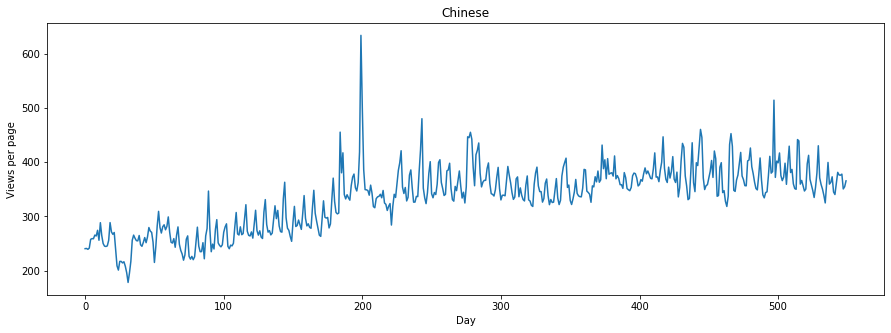

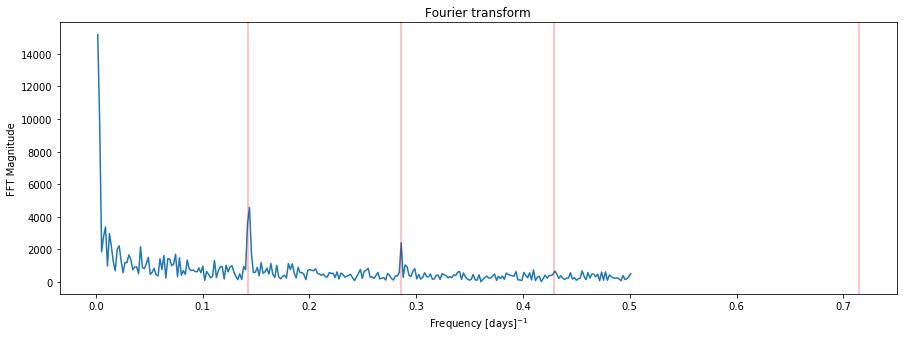

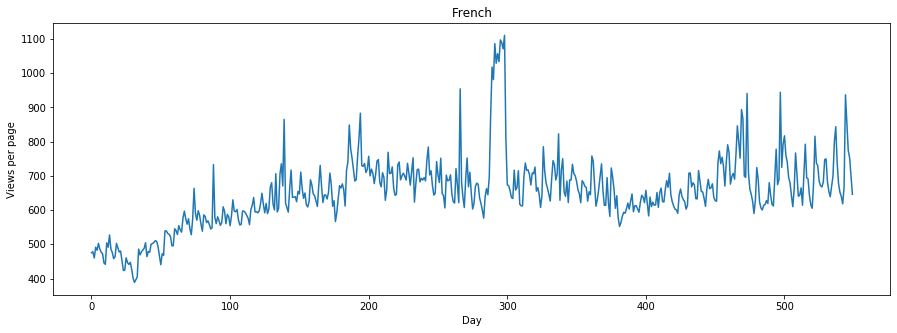

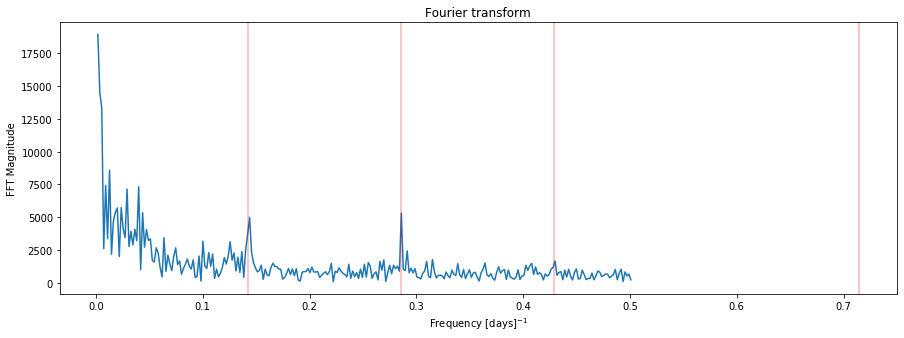

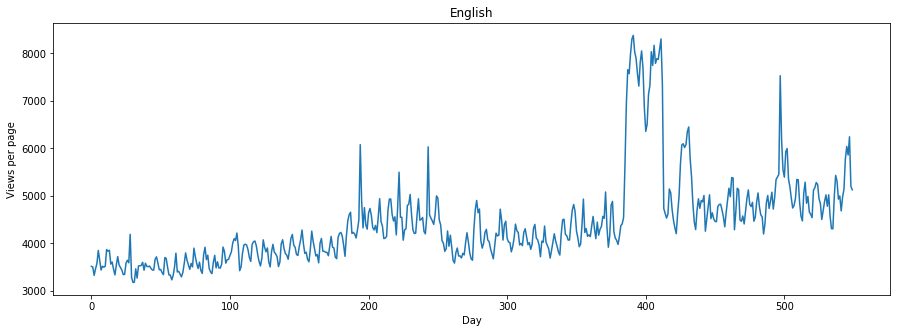

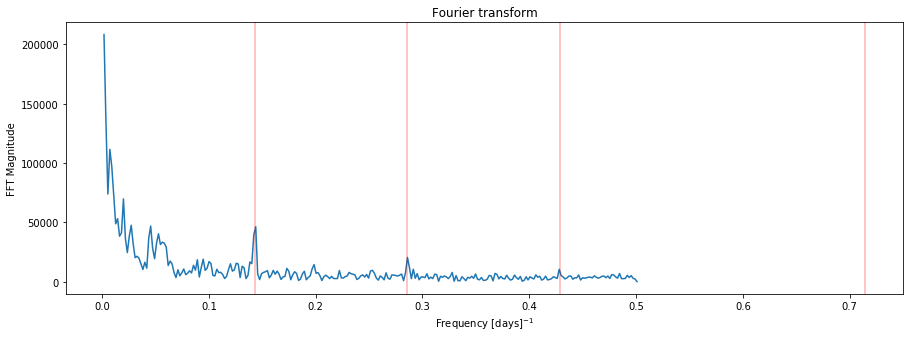

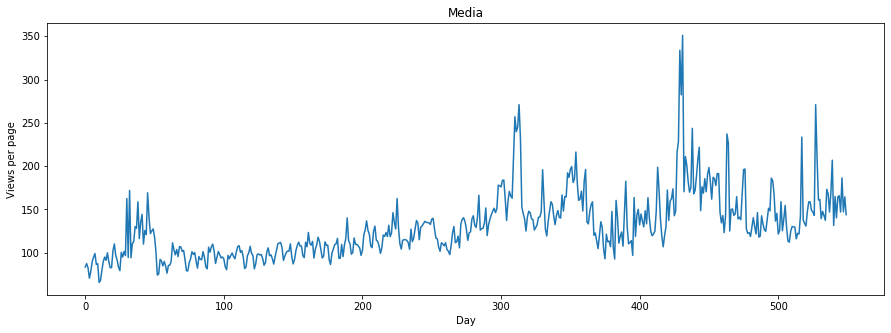

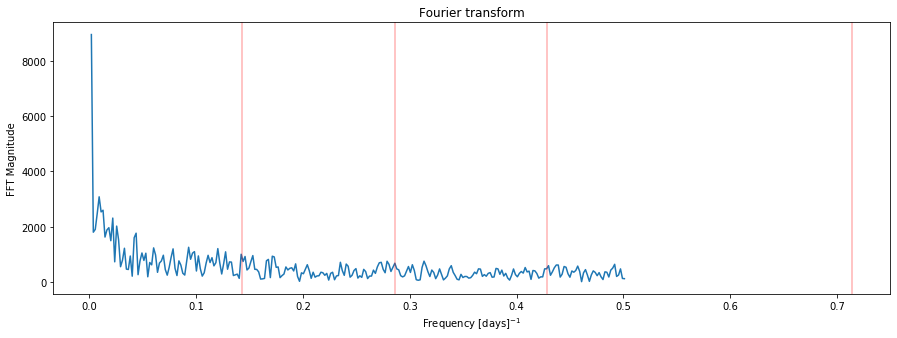

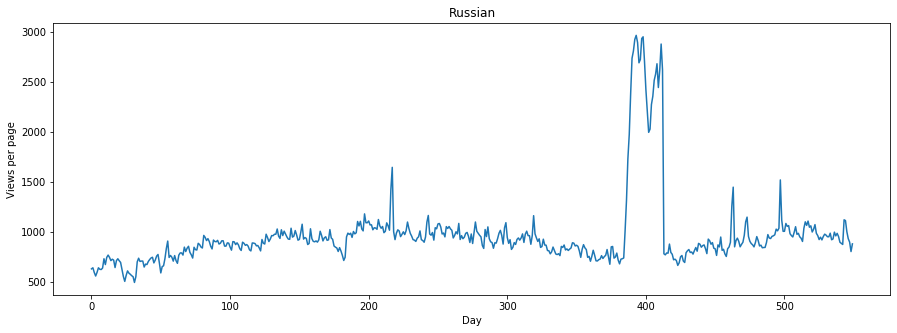

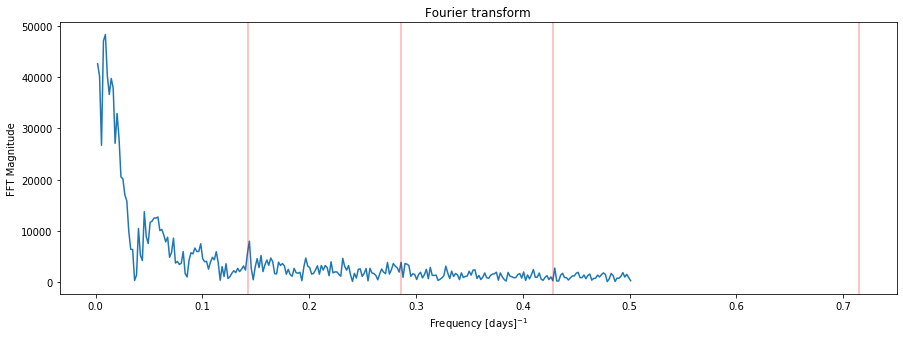

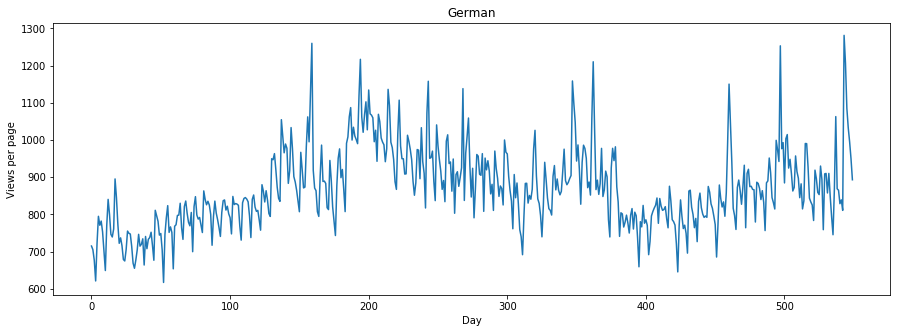

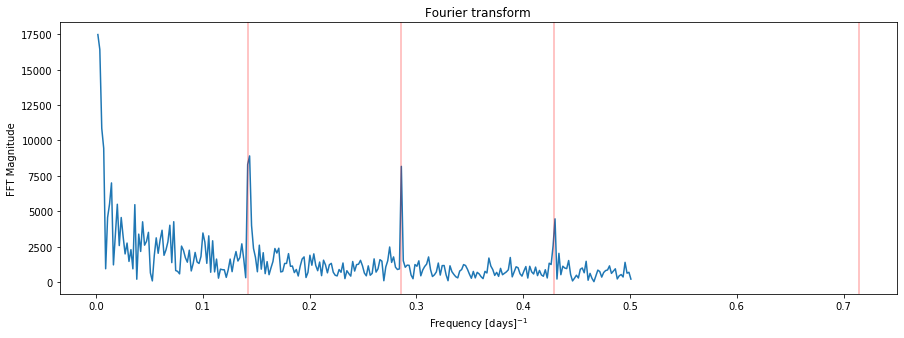

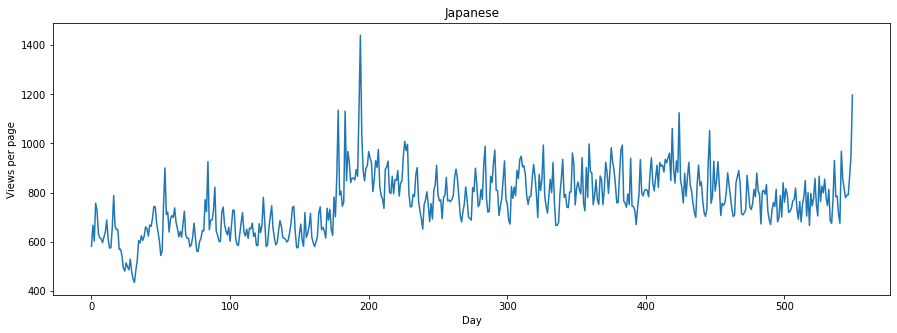

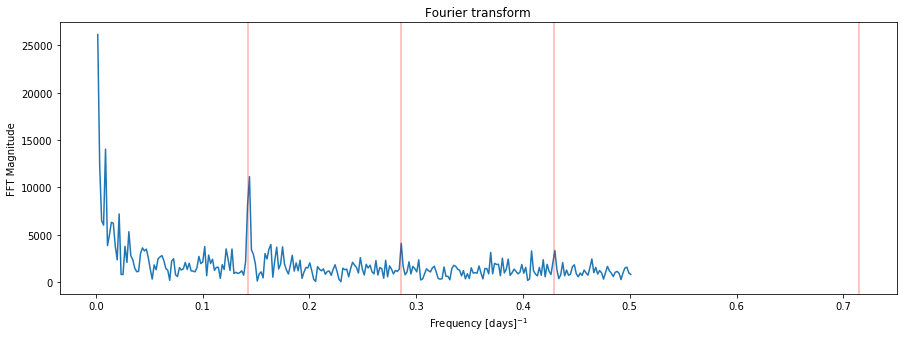

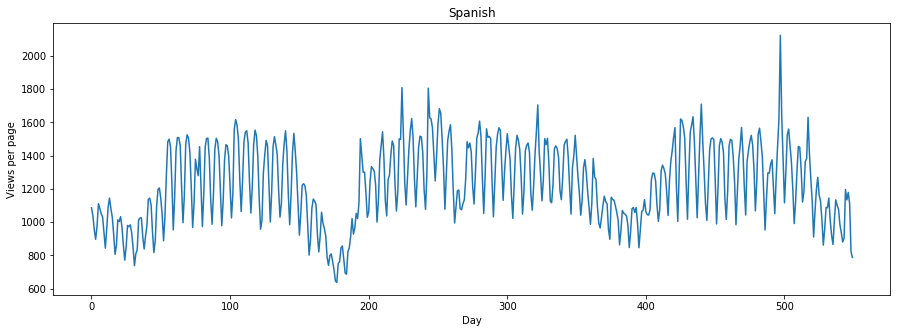

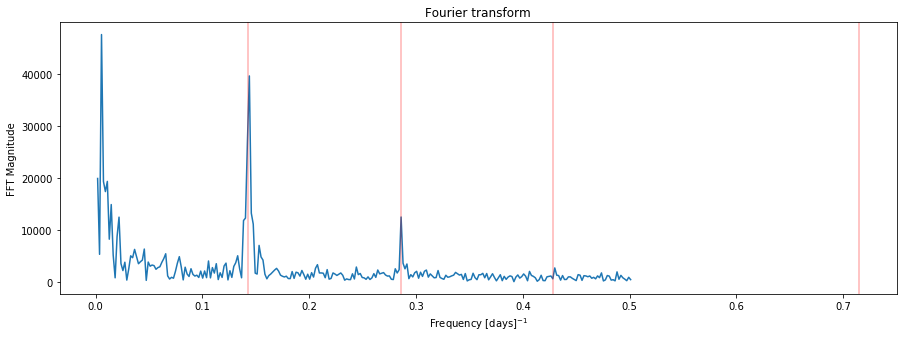

In [26]:
def plot_with_fft(key):
    fig = plt.figure(1, figsize=[15, 5])
    plt.ylabel("Views per page")
    plt.xlabel("Day")
    plt.title(labels[key])
    plt.plot(days, sums[key], label = labels[key])
    
    fig = plt.figure(2, figsize=[15, 5])
    # we plot the ftt freq on the x axis
    # and the magnitude of the vector (how big is it) on the y axis
    fft_complex = fft(sums[key])
    # magnitude is sqrt(a*a + b*b), a is real(x) while b is imaginary(x)
    fft_mag = [np.sqrt(np.real(x)**2 + np.imag(x)**2) for x in fft_complex]
    # norm values of days
    fft_xvals = [day / days[-1] for day in days]
    npts = len(fft_xvals) // 2 + 1
    # analyzing half of the dataset to have a zoomed view
    # also the whole fourier series is specular
    fft_mag = fft_mag[:npts]
    fft_xvals = fft_xvals[:npts]
    
    plt.ylabel("FFT Magnitude")
    plt.xlabel(r"Frequency [days]$^{-1}$")
    plt.title("Fourier transform")
    plt.plot(fft_xvals[1:], fft_mag[1:], label = labels[key])
    # Draw lines at 1, 1/2 and 1/3 week periods
    plt.axvline(x=1./7, color="red", alpha=0.3)
    plt.axvline(x=2./7, color="red", alpha=0.3)
    plt.axvline(x=3./7, color="red", alpha=0.3)
    
    plt.show()
    
for key in sums:
    plot_with_fft(key)

let's plot some individual page views

In [27]:
def plot_entry(key, idx):
    data = lang_sets[key].iloc[idx, 1:]
    fig = plt.figure(1, figsize=(10, 5))
    plt.plot(days, data)
    plt.xlabel("day")
    plt.ylabel("views")
    plt.title(train.iloc[lang_sets[key].index[idx], 0])
    
    plt.show()

We can see from the individual data analyzed down here that the views for each page are not following a constant trend but are jumping when something occours, like for the 2016 shooting at the OG

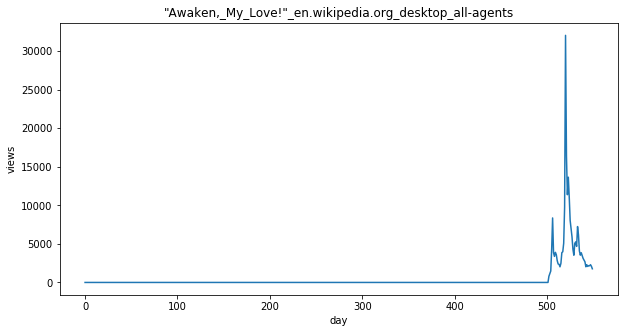

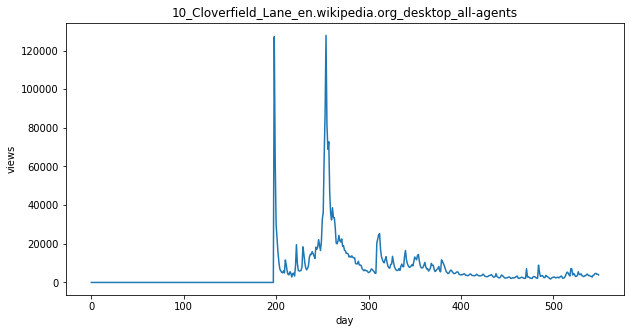

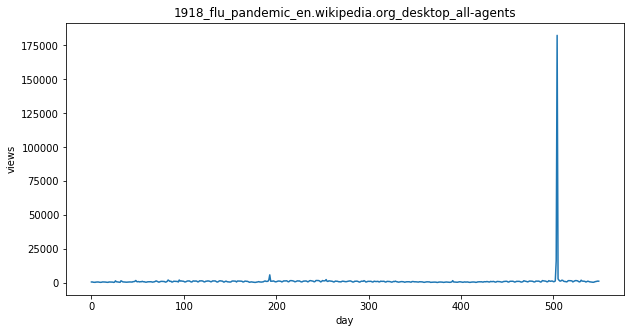

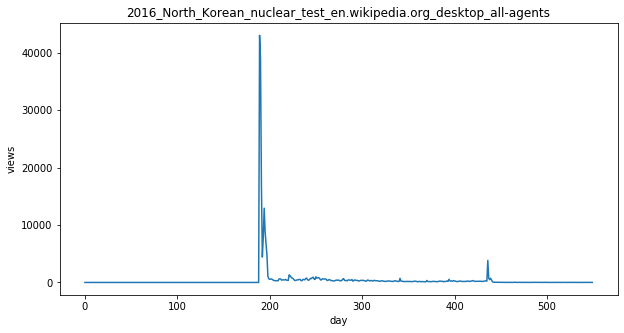

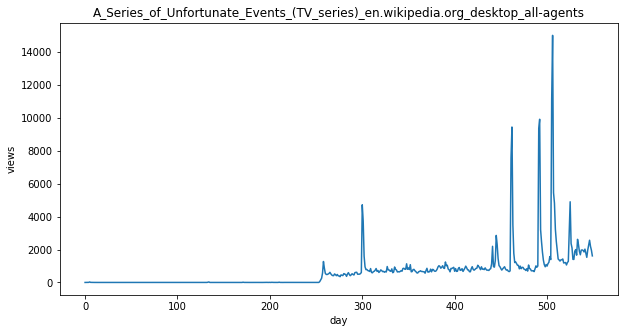

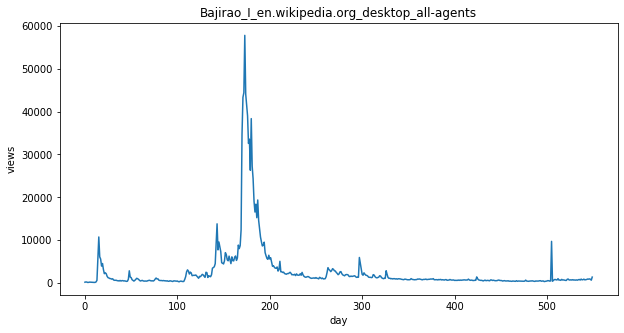

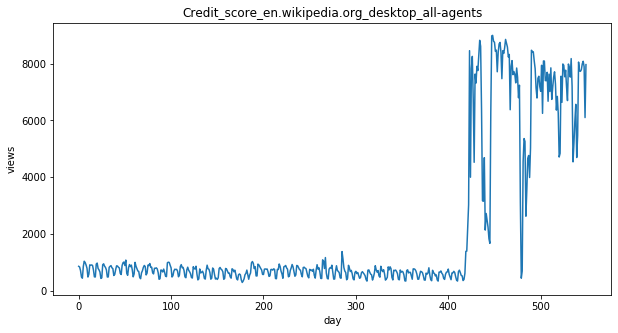

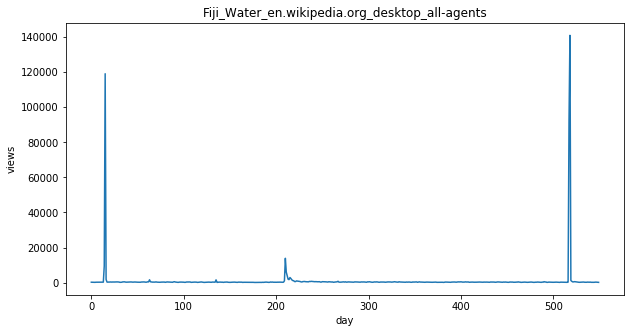

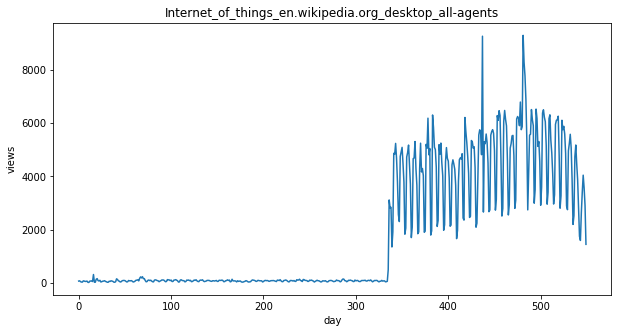

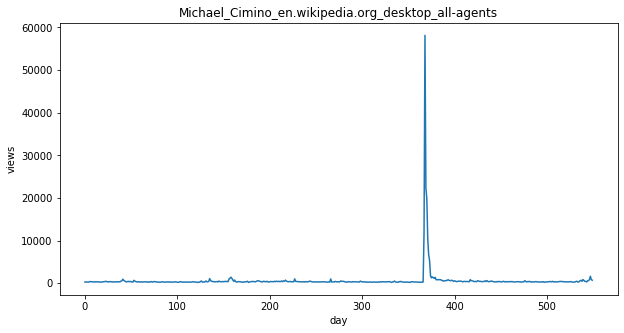

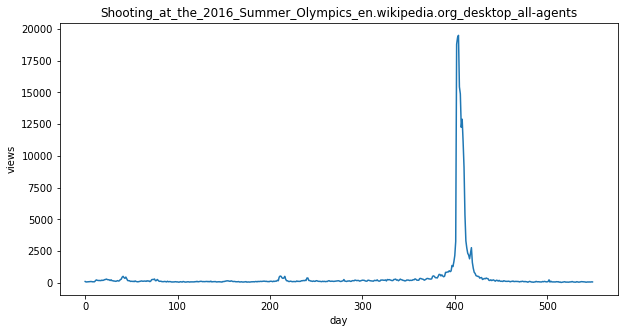

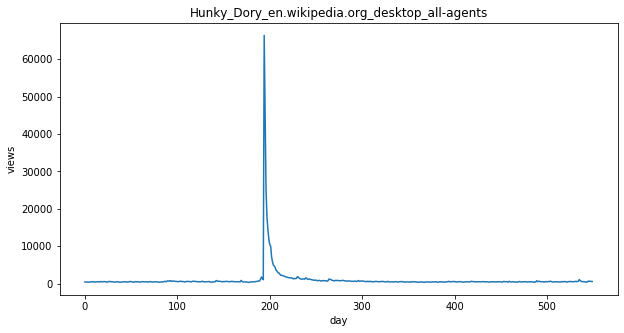

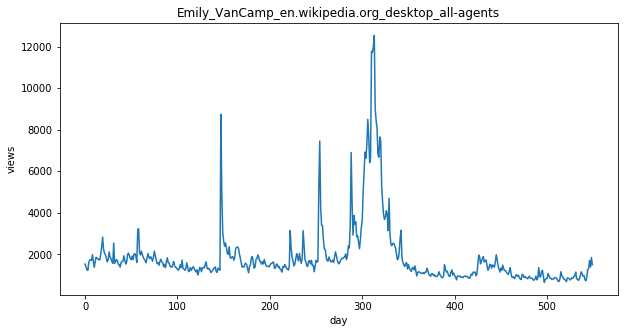

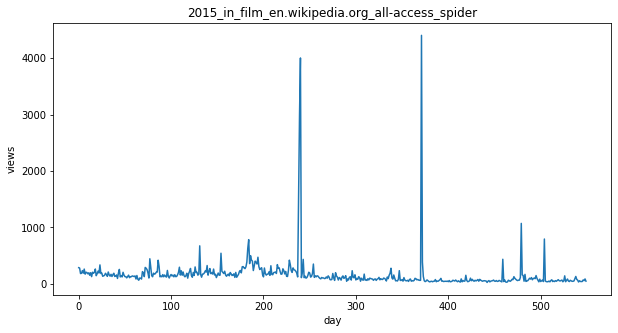

In [28]:
idx = [1, 5, 10, 50, 100, 250, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000]
for i in idx:
    plot_entry("en", i)

In [34]:
# Show pages with the biggest view count
npages = 5
top_pages = {}
for key in lang_sets:
    print(key)
    sum_set = pd.DataFrame(lang_sets[key]["Page"])
    sum_set["total"] =lang_sets[key].sum(axis=1)
    sum_set = sum_set.sort_values("total", ascending=False)
    print(sum_set.head(10))
    top_pages[key] = sum_set.index[0]
    print("\n\n")

zh
                                                     Page      total
28727   Wikipedia:首页_zh.wikipedia.org_all-access_all-a...  123694312
61350    Wikipedia:首页_zh.wikipedia.org_desktop_all-agents   66435641
105844  Wikipedia:首页_zh.wikipedia.org_mobile-web_all-a...   50887429
28728   Special:搜索_zh.wikipedia.org_all-access_all-agents   48678124
61351      Special:搜索_zh.wikipedia.org_desktop_all-agents   48203843
28089   Running_Man_zh.wikipedia.org_all-access_all-ag...   11485845
30960   Special:链接搜索_zh.wikipedia.org_all-access_all-a...   10320403
63510    Special:链接搜索_zh.wikipedia.org_desktop_all-agents   10320336
60711     Running_Man_zh.wikipedia.org_desktop_all-agents    7968443
30446    瑯琊榜_(電視劇)_zh.wikipedia.org_all-access_all-agents    5891589
28727



fr
                                                     Page      total
27330   Wikipédia:Accueil_principal_fr.wikipedia.org_a...  868480667
55104   Wikipédia:Accueil_principal_fr.wikipedia.org_m...  611302821
7344    Wikipédia:A

/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 39318 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 39029 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 39318 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 39029 missing from current font.
  font.set_text(s, 0, flags=flags)


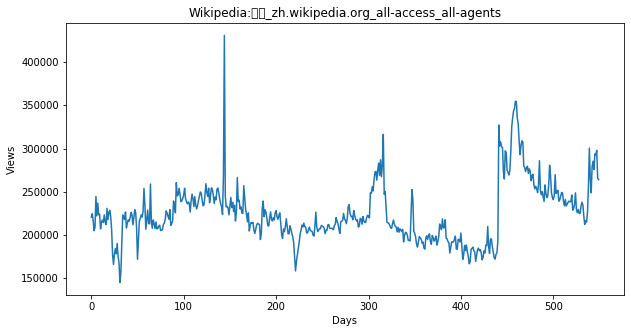

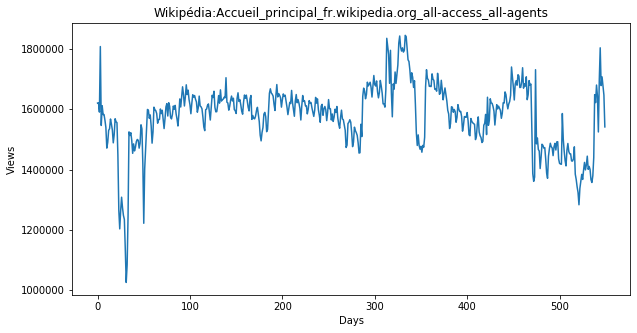

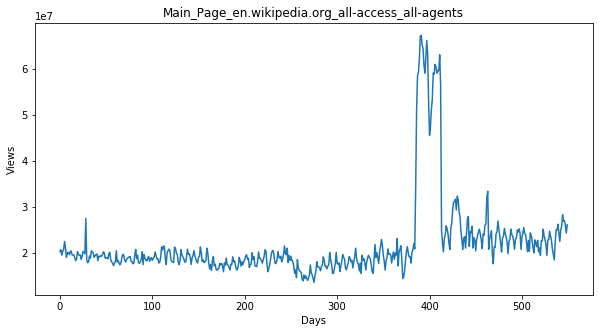

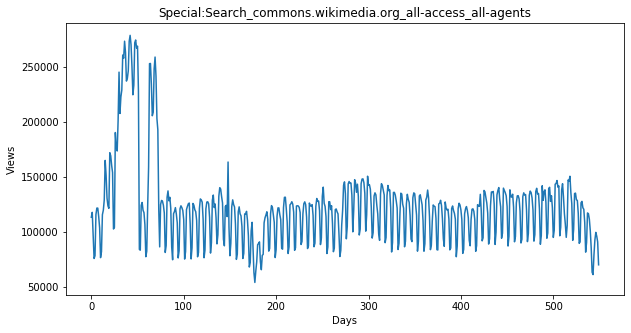

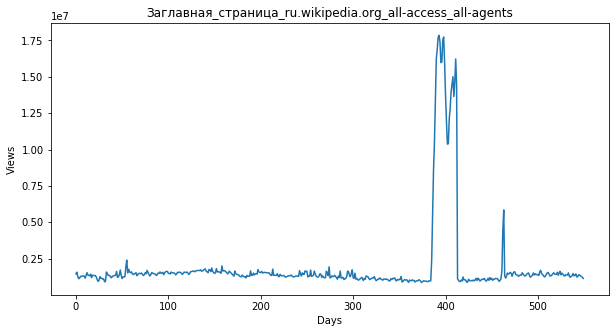

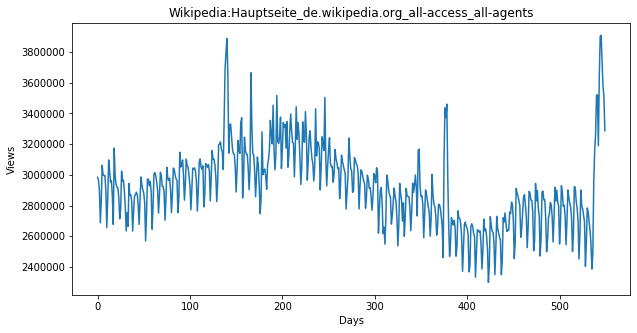

/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12513 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12531 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12506 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/animalecs/.pyenv/versions/3.7.3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/User

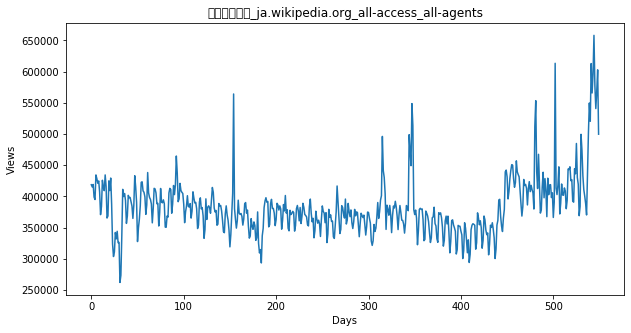

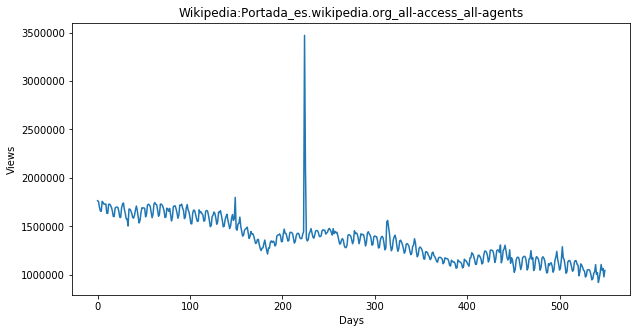

In [33]:
for key in top_pages:
    fig = plt.figure(1, figsize=(10, 5))
    cols = train.columns
    cols = cols[1:-1]
    data = train.loc[top_pages[key], cols]
    plt.plot(days, data)
    plt.xlabel("Days")
    plt.ylabel("Views")
    plt.title(train.loc[top_pages[key], "Page"])
    plt.show()

The big difference between the aggregated data of the views and the individual suggests that the 